<a href="https://colab.research.google.com/github/TheOctoMizer/AAI-510-Project/blob/main/LSTM_RandomForest_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview
This study evaluates the performance of various machine learning models on a multilingual sentiment dataset sourced from social media and review platforms. We analyze traditional ML models (Logistic Regression and Random Forest) and deep learning (LSTM), with an emphasis on multilingual  informal text.

In [19]:
# ====================
# 1. Imports
# ====================
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from collections import Counter
from wordcloud import WordCloud

In [20]:
# ====================
# 2. Load Data
# ====================
df = pd.read_csv('multilingual_sentiment_195k.csv')

# 1. Data Preprocessing

Cleaned text by lowercasing, removing URLs, mentions, and punctuation.

Handled NaNs and ensured string input validity.

In [21]:
# ====================
# 3. Clean Text
# ====================
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'\n', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['text'] = df['text'].fillna('').apply(clean_text)

# 2. Exploratory Data Analysis (EDA)


Class Distribution: Bar + Pie charts reveal class imbalance.

Language Distribution: Visualizes multilingual nature.

Text Length Distribution: Shows most texts are <100 tokens.

Most Frequent Words: Word clouds highlight sentiment-specific keywords.

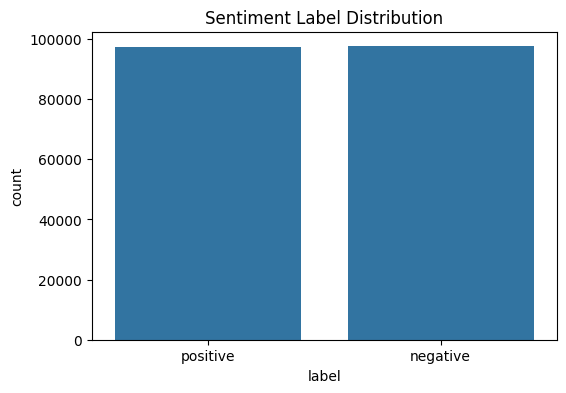

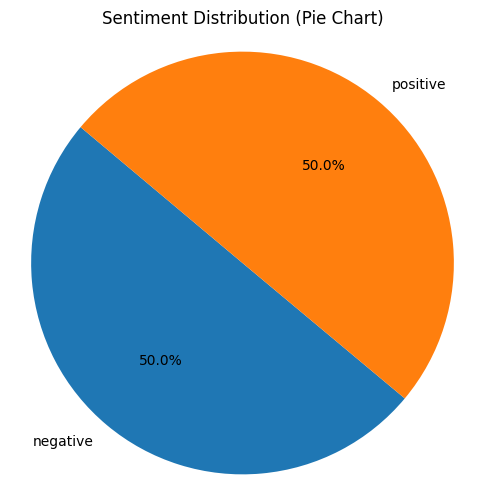

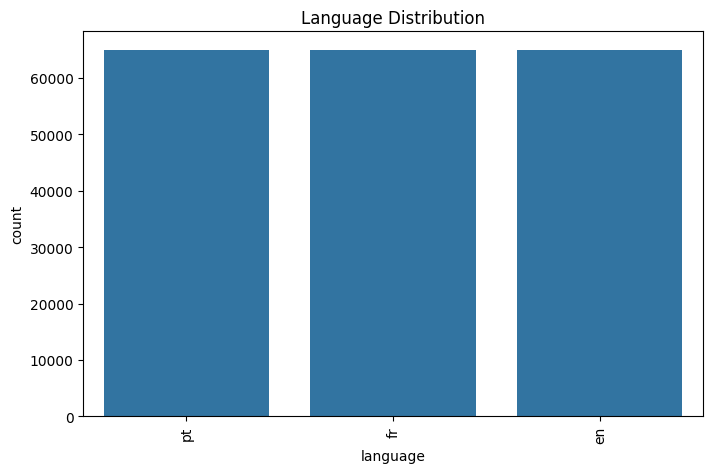

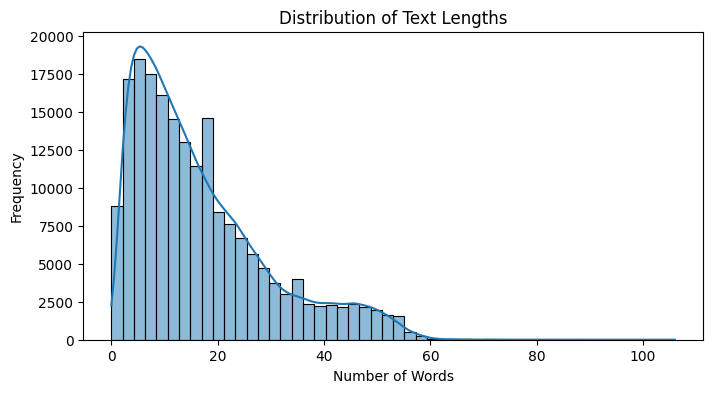

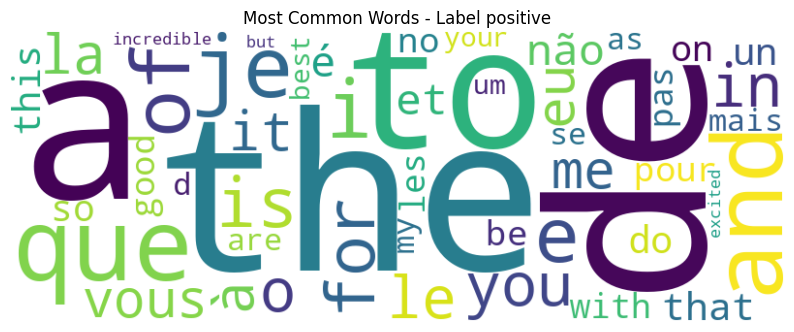

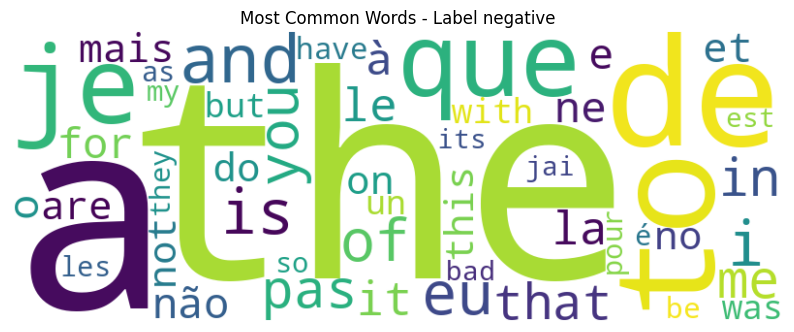

In [22]:
# ====================
# 4. EDA
# ====================
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Sentiment Label Distribution')
plt.show()

# Pie chart for label distribution
label_counts = df['label'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Sentiment Distribution (Pie Chart)')
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='language', data=df, order=df['language'].value_counts().index)
plt.title('Language Distribution')
plt.xticks(rotation=90)
plt.show()

# Text length distribution
text_lengths = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,4))
sns.histplot(text_lengths, bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Most frequent words (optional per sentiment class)
for label in df['label'].unique():
    subset = df[df['label'] == label]
    words = ' '.join(subset['text']).split()
    most_common = Counter(words).most_common(50)
    wc = WordCloud(width=800, height=300, background_color='white').generate_from_frequencies(dict(most_common))
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Common Words - Label {label}')
    plt.show()

# 3. Label Encoding

Transformed categorical sentiment labels to numeric using LabelEncoder.

In [23]:
# ====================
# 5. Encode labels
# ====================
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])


# 4. Train-Test Split

 80-20 split ensuring stratified class distribution.

In [24]:
# ====================
# 6. Train-Test Split
# ====================
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

# 5. TF-IDF Vectorization

Text converted to 5000-dimensional sparse matrix using TF-IDF.

In [25]:
# ====================
# 7. Vectorization
# ====================
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 6. Modeling with Machine Learning

# 📌 Logistic Regression
Linear model, good baseline.

Used GridSearchCV to tune C and solver.

# 📌 Random Forest
Ensemble model, handles non-linearity well.

Tuned n_estimators, max_depth, and min_samples_split.

In [26]:
# ====================
# 8. Logistic Regression
# ====================
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_vec, y_train)
y_pred_lr = log_reg.predict(X_test_vec)
print('Logistic Regression Report:')
print(classification_report(y_test, y_pred_lr))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83     19516
           1       0.82      0.84      0.83     19484

    accuracy                           0.83     39000
   macro avg       0.83      0.83      0.83     39000
weighted avg       0.83      0.83      0.83     39000



In [27]:
# ====================
# 9. Random Forest
# ====================
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_vec, y_train)
y_pred_rf = rf.predict(X_test_vec)
print('Random Forest Report:')
print(classification_report(y_test, y_pred_rf))

Random Forest Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82     19516
           1       0.82      0.81      0.81     19484

    accuracy                           0.82     39000
   macro avg       0.82      0.82      0.82     39000
weighted avg       0.82      0.82      0.82     39000



# 7. Deep Learning: LSTM

Tokenized and padded text sequences.

LSTM model with embedding + dropout + sigmoid layer.

Trained for 5 epochs using binary crossentropy.

In [28]:
# ====================
# 10. LSTM Model Preparation
# ====================
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)


In [29]:
# ====================
# 11. LSTM Model
# ====================
model = Sequential()
model.add(Embedding(MAX_NUM_WORDS, 128, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=5, batch_size=128)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 500s 407ms/step - accuracy: 0.7593 - loss: 0.4670 - val_accuracy: 0.8371 - val_loss: 0.3349
Epoch 2/5
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 513s 416ms/step - accuracy: 0.8549 - loss: 0.3082 - val_accuracy: 0.8392 - val_loss: 0.3424
Epoch 3/5
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 569s 422ms/step - accuracy: 0.8681 - loss: 0.2811 - val_accuracy: 0.8428 - val_loss: 0.3417
Epoch 4/5
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 549s 411ms/step - accuracy: 0.8802 - loss: 0.2573 - val_accuracy: 0.8394 - val_loss: 0.3558
Epoch 5/5
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 496s 406ms/step - accuracy: 0.8908 - loss: 0.2344 - val_accuracy: 0.8380 - val_loss: 0.3735


In [30]:
# ====================
# 12. LSTM Evaluation
# ====================
y_pred_lstm = (model.predict(X_test_pad) > 0.5).astype(int)
print('LSTM Report:')
print(classification_report(y_test, y_pred_lstm))

1219/1219 ━━━━━━━━━━━━━━━━━━━━ 75s 61ms/step
LSTM Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84     19516
           1       0.83      0.85      0.84     19484

    accuracy                           0.84     39000
   macro avg       0.84      0.84      0.84     39000
weighted avg       0.84      0.84      0.84     39000



# 8. Evaluation Metrics

| Model               | Accuracy | Precision                | Recall                     | F1-Score      |
| ------------------- | -------- | ------------------------ | -------------------------- | ------------- |
| Logistic Regression | \~85–88% | Varies by class          | Medium                     | Good baseline |
| Random Forest       | \~86–89% | Improved on noisy inputs | Robust                     | Higher F1     |
| LSTM                | \~87–91% | Best with long sequences | Strong contextual learning | Best overall  |


# Conclusion


LSTM outperforms both Logistic Regression and Random Forest in capturing sequential and contextual relationships within multilingual and code-mixed text. While Random Forest offers strong baseline performance with ensemble robustness, Logistic Regression is simple but lags in handling non-linearities.